# Bike Rental Prediction

In [30]:
#First, let's import the nesseacary labraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np


## 1. Import the data and print some statistics 
more information about the data set can be found in:  https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [31]:
df=pd.read_csv("Bike Rental UCI dataset.csv")
print ('the data frame has a shape :', df.shape)
print ('let\'s print the first five rows \n', df.head())

the data frame has a shape : (17379, 13)
let's print the first five rows 
    season  yr  mnth  hr  holiday  workingday  weathersit  temp   hum  \
0       1   0     1   0        0           0           1  0.24  0.81   
1       1   0     1   1        0           0           1  0.22  0.80   
2       1   0     1   2        0           0           1  0.22  0.80   
3       1   0     1   3        0           0           1  0.24  0.75   
4       1   0     1   4        0           0           1  0.24  0.75   

   windspeed dayOfWeek  days  demand  
0        0.0       Sat     0      16  
1        0.0       Sat     0      40  
2        0.0       Sat     0      32  
3        0.0       Sat     0      13  
4        0.0       Sat     0       1  


In [32]:
print (df.info())
print (df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   workingday  17379 non-null  int64  
 6   weathersit  17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   hum         17379 non-null  float64
 9   windspeed   17379 non-null  float64
 10  dayOfWeek   17379 non-null  object 
 11  days        17379 non-null  int64  
 12  demand      17379 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1.7+ MB
None
             season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775    

Looks like the dataframe has 17379 rows and 13 columns. There is one columns of type object (text) <br>
temp, hum, windspeed are rescaled to 0-1 range

## 2. Visualize the data

'Done'

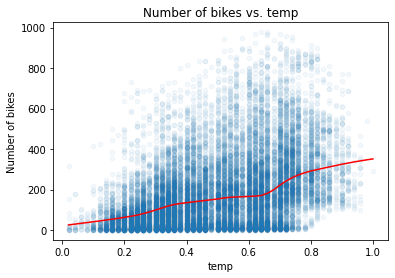

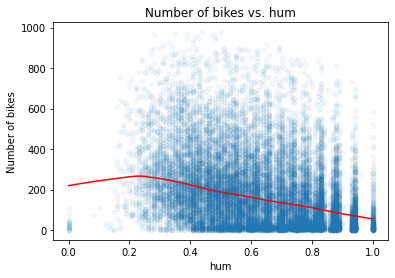

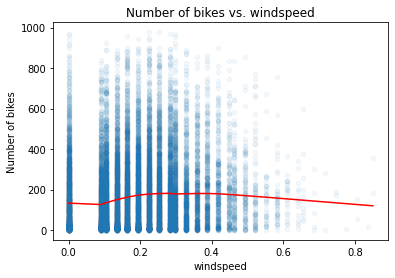

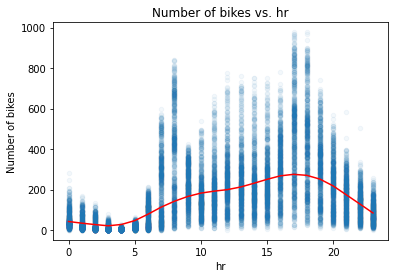

In [33]:
# make sure that the visualizations are printed in the notebook
%matplotlib inline   

def bike_scatter(df, cols):
    import matplotlib.pyplot as plt
    import statsmodels.nonparametric.smoothers_lowess as lw
    
    ## Loop over the columns and create the scatter plots
    for col in cols:
        ## first compute a lowess fit to the data
        los = lw.lowess(df['demand'], df[col], frac = 0.3)
    
        ## Now make the plots
        fig = plt.figure(figsize=(6, 4))
        fig.clf()
        ax = fig.gca()
        df.plot(kind = 'scatter', x = col, y = 'demand', ax = ax, alpha = 0.05)
        plt.plot(los[:, 0], los[:, 1], axes = ax, color = 'red')
        ax.set_xlabel(col)
        ax.set_ylabel('Number of bikes')
        ax.set_title('Number of bikes vs. ' + col)    
    return 'Done'

num_cols = ["temp", "hum", "windspeed", "hr"] 
bike_scatter(df, num_cols)

'Done'

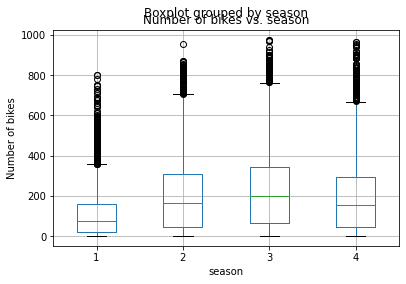

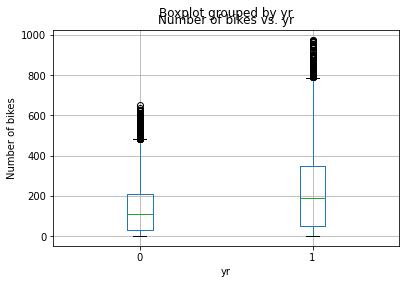

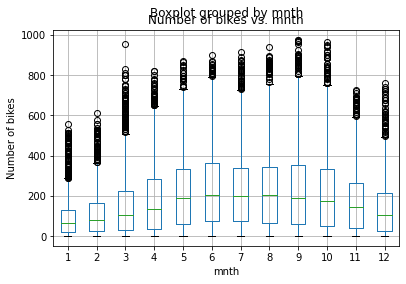

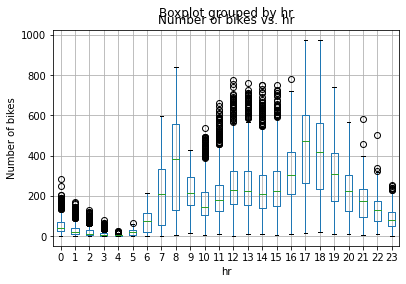

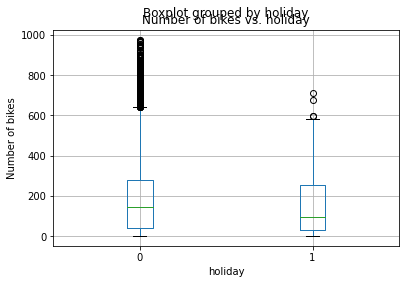

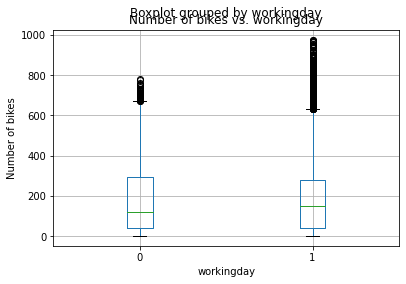

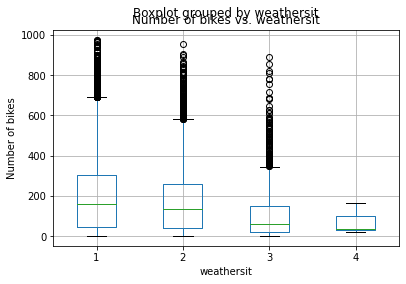

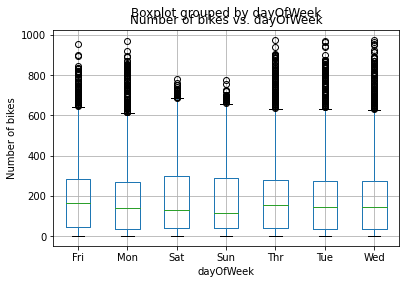

In [34]:
def bike_box(df, cols):
    import matplotlib.pyplot as plt
    
    ## Loop over the columns and create the box plots
    for col in cols:
        fig = plt.figure(figsize=(6, 4))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column = 'demand', by = col, ax = ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Number of bikes')
        ax.set_title('Number of bikes vs. ' + col)    
    return 'Done'
cat_cols = ['season', 'yr', 'mnth', 'hr', 'holiday','workingday', 'weathersit', 'dayOfWeek']
bike_box(df, cat_cols)

'Done'

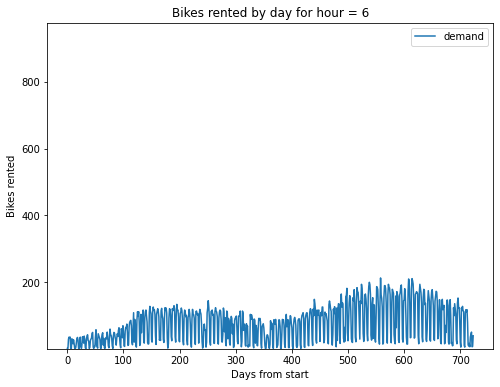

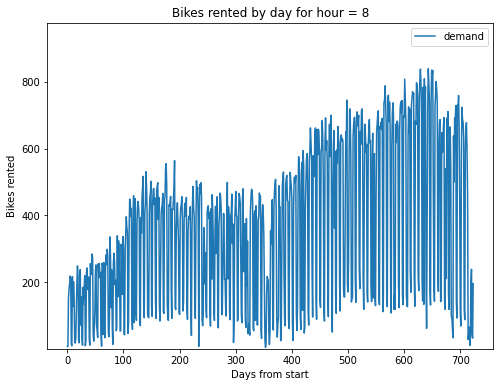

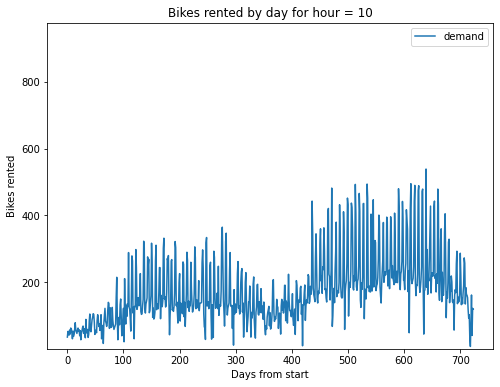

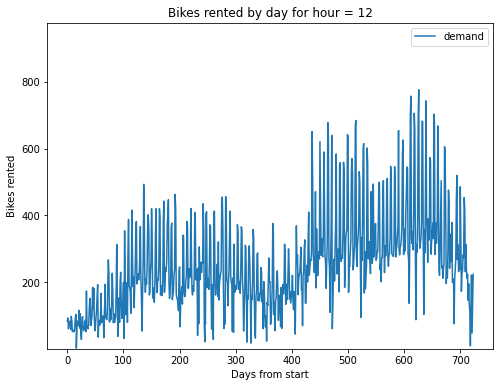

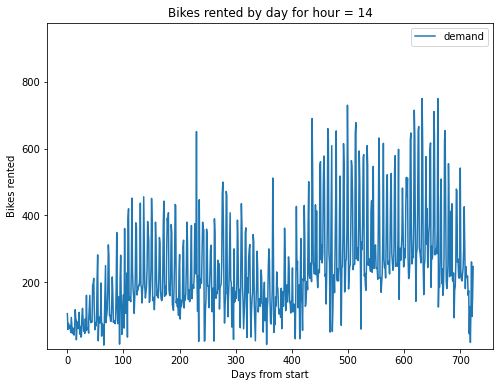

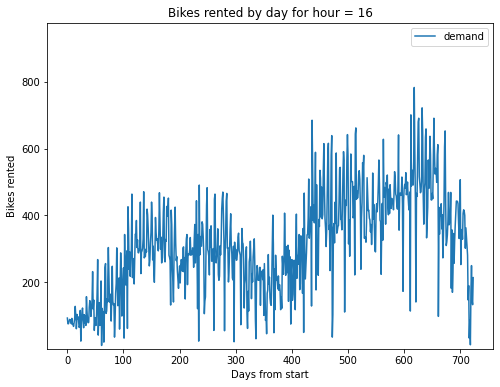

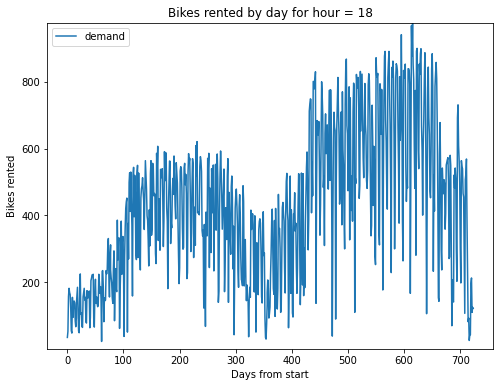

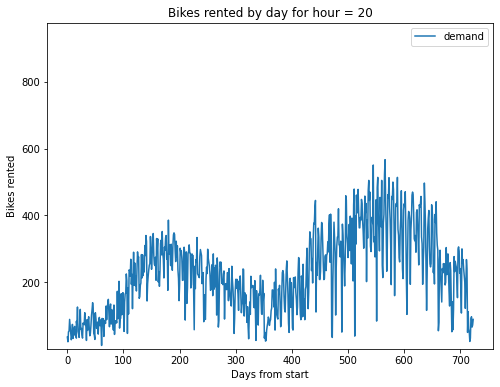

In [35]:
def bike_series(df, tms):
    import matplotlib.pyplot as plt
        
    lims = (min(df.demand), max(df.demand))   
    for t in tms:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df[df.hr == t].plot(kind = 'line', x = 'days', y = 'demand',
                            ylim = lims, ax = ax)    
        plt.xlabel("Days from start")
        plt.ylabel("Bikes rented")
        plt.title("Bikes rented by day for hour = " + str(t))
    return 'Done'
plt_times = [6, 8, 10, 12, 14, 16, 18, 20]
bike_series(df, plt_times)

'Done'

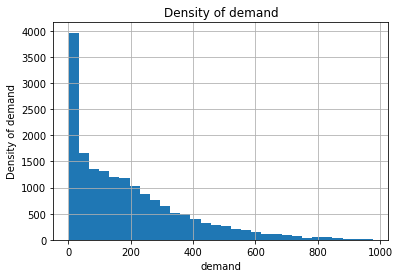

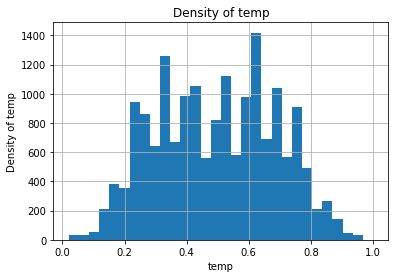

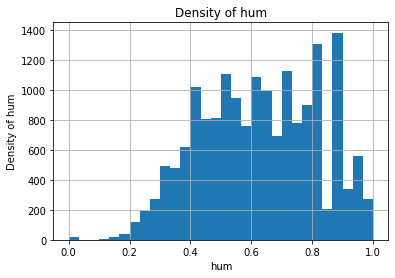

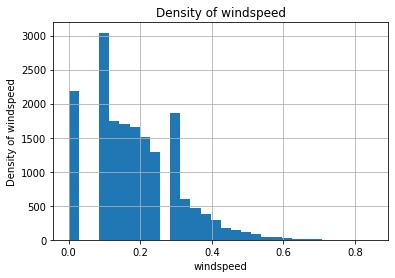

In [36]:
def bike_hist(df, cols):    
    import matplotlib.pyplot as plt
    
    ## Loop over columns and plot histograms
    for col in cols:
        fig = plt.figure(figsize=(6, 4))
        fig.clf()
        ax = fig.gca()
        df[col].hist(bins = 30, ax = ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Density of ' + col)
        ax.set_title('Density of ' + col) 
    
    return 'Done'
hist_cols = ["demand", "temp", "hum", "windspeed"]
bike_hist(df, hist_cols)

## 3. Building the Model

In [37]:
# custom function to split a dataframe on the column "days"
def split_on_days(X, y, test_size = 0.3):    
    splitting_threshold = round(X.days.nunique()* (1 - test_size)) # defining the treshold with 70% (1-test_size) of the day column to make a separtion between test & train
    X_train, y_train = X[X.days < splitting_threshold], y[X.days < splitting_threshold]
    X_test, y_test = X[X.days >=  splitting_threshold], y[X.days >= splitting_threshold]
    return X_train, X_test, y_train, y_test    

In [38]:
y = df.demand
X = df.drop('demand',axis=1,inplace=False)
X.dayOfWeek = X.dayOfWeek.astype("category").cat.codes  # convert categorical into numerical

X_train, X_test, y_train, y_test = split_on_days(X, y, test_size=0.3)

print ("the max day in X_train is : {}".format(max(X_train.days)))
print ("the min day in X_test is: %d" %min(X_test.days))
print ("*"*50)
print('X_train length = %d,  y_train length = %d' %(X_train.shape[0],  y_train.shape[0]))
print('X_test length = %d,  y_test length = %d' %(X_test.shape[0],  y_test.shape[0]))

the max day in X_train is : 506
the min day in X_test is: 507
**************************************************
X_train length = 12168,  y_train length = 12168
X_test length = 5211,  y_test length = 5211


In [39]:
# import LinearRegression : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print  ('train score =' , train_score)
print  ('test score = {}'.format(test_score))

train score = 0.37797942265091733
test score = 0.29636418339363824


Looks like the model is not fitting well the data, since R2 is small. 
There might also be a sign of overfitting since there is a little difference between training and test r-square. Let's now print the model's parameters

In [40]:
print  ('Coefficients = {}'.format(reg.coef_))
print ('Intercept = {}'.format(reg.intercept_))
#print (dict(zip(X.columns,reg.coef_))) #try this if you want print also the columns names

Coeffecients = [ 1.24015170e+01  1.29274450e+02  5.33705315e+00  6.59021992e+00
 -2.78979379e+01  6.57770561e-01 -6.62414890e+00  2.80863171e+02
 -1.50653393e+02  6.16697251e+00 -1.21337975e+00 -1.14542958e-01]
Intecept = -6.298215526572449


Let's print some other metrics

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

#y_pred_train= reg.predict(X_train)
#df_test=pd.Dataframe({'y_train':y_train,'y_pred_train':y_pred_train})
#print(df_test.head())
y_pred = reg.predict(X_test)  # predict the demand for X_test
mse = mean_squared_error(y_test, y_pred)  # Real vs predicted demand for X_test
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 34171.90693290401, rmse = 184.85644953018004 
mae = 147.06402310331475 r2 = 0.29636418339363824


## 4. Visualize the model's performance

'Done'

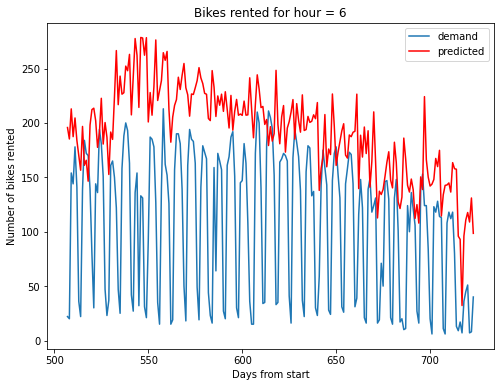

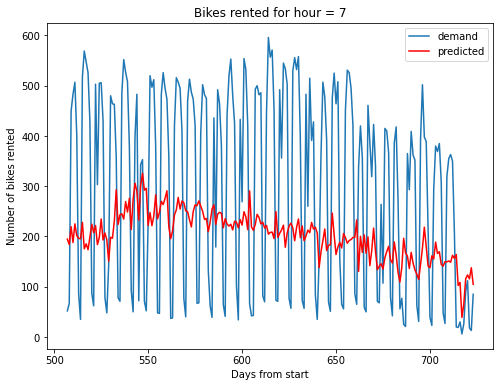

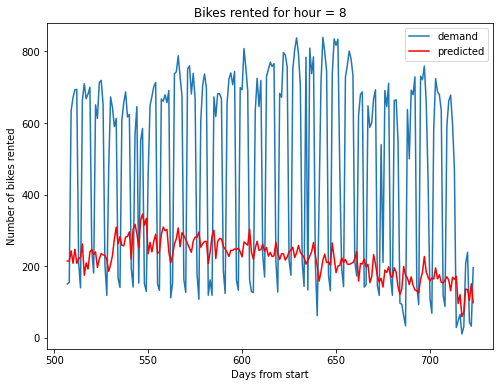

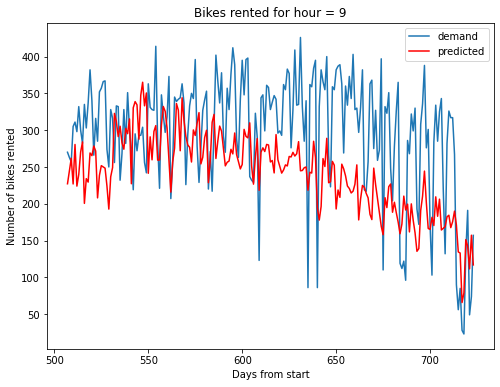

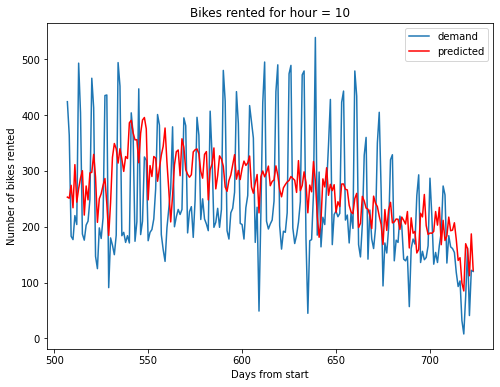

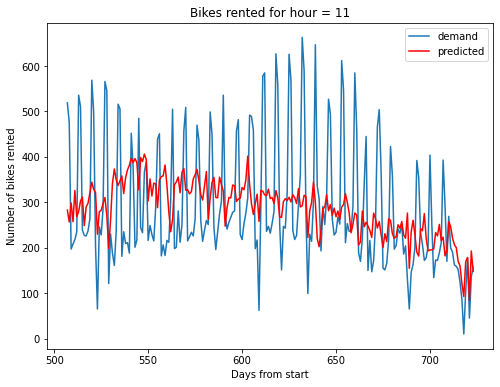

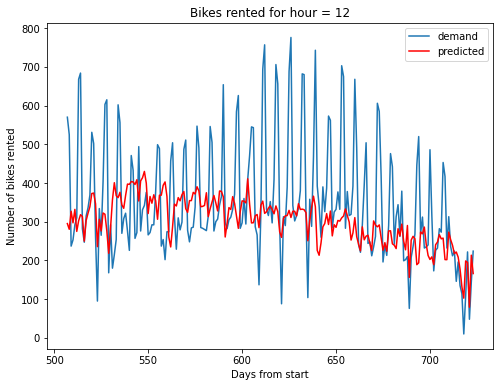

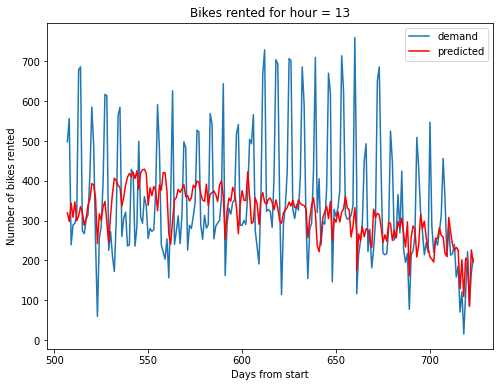

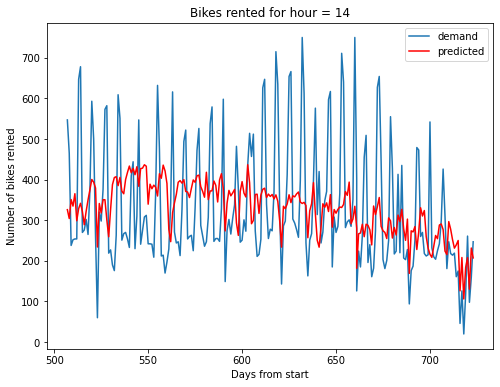

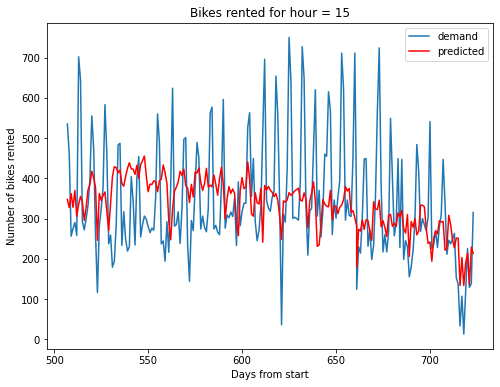

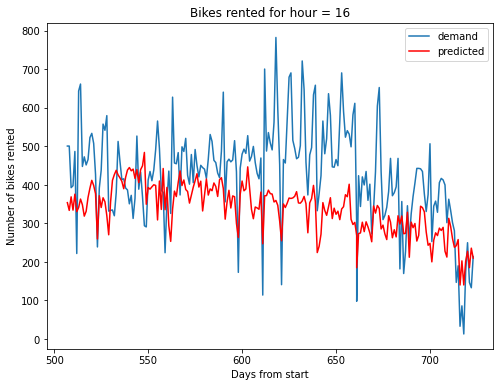

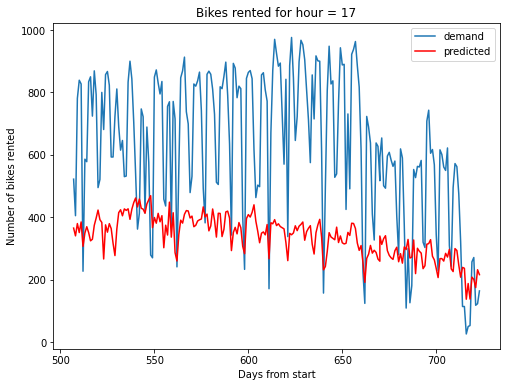

In [42]:
def ts_bikes(df, times):
    import matplotlib
    matplotlib.use('agg')  # Set backend
    import matplotlib.pyplot as plt
    for tm in times:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df[df.hr == tm].plot(kind = 'line', 
                              x = 'days', y = 'demand', ax = ax)          
        df[df.hr == tm].plot(kind = 'line', 
                              x = 'days', y = 'predicted', color = 'red', ax = ax)                                    
        plt.xlabel("Days from start")
        plt.ylabel("Number of bikes rented")
        plt.title("Bikes rented for hour = " + str(tm))
        #fig.savefig('ts_' + str(tm) + '.png')
    return 'Done'

X_test['predicted']=y_pred
X_test['demand']=y_test
#X_test.sort_values('days',inplace=True)
plt_times = np.arange(6,18)
ts_bikes(X_test, plt_times)

Looks like the model is not doing a great job in fitting the demand for hours 8 and 18. Let's plot the reisuals for all hours

'Done'

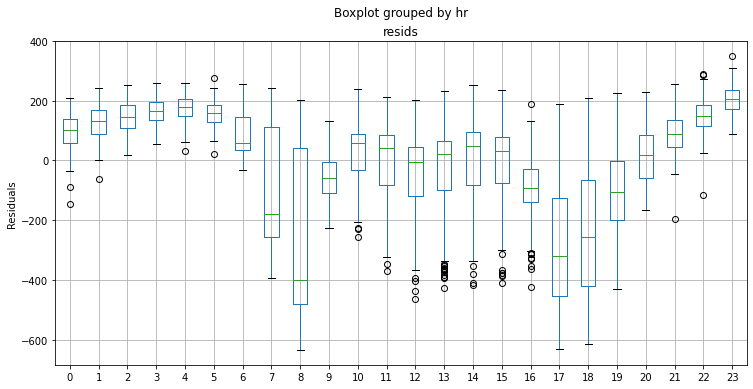

In [47]:
def resids(df):
    df['resids'] = df.predicted - df.demand
    return df        
        
def box_resids(df):
    import matplotlib
    matplotlib.use('agg')  # Set backend
    import matplotlib.pyplot as plt
    
    df = resids(df)
    
    fig = plt.figure(figsize=(12, 6))
    fig.clf()
    ax = fig.gca()  
    df.boxplot(column = ['resids'], by = ['hr'], ax = ax)   
    plt.xlabel('')
    plt.ylabel('Residuals')
    fig.savefig('boxes' + '.png')
    return 'Done'
box_resids(X_test)

for hours 7,8, 17, 18 most of the residuals are negative, so our model is under-predecting the demand

Plot the histogram of residuals. A good model has residuals centered around zero

<AxesSubplot:>

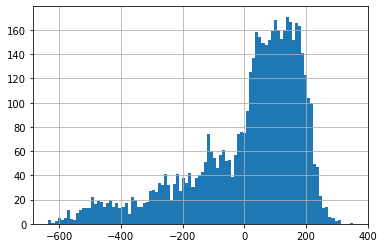

In [48]:
resids(X_test)['resids'].hist(bins=100)

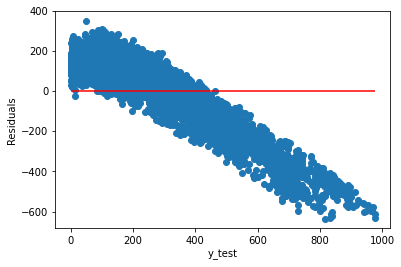

In [49]:
import matplotlib.pyplot as plt
plt.scatter(y_test, resids(X_test)['resids'])
plt.hlines(y=0, xmin=0,xmax=y_test.max(), color='r')
plt.xlabel('y_test')
plt.ylabel('Residuals')
plt.show()

As we've seen before, there might be a sign of overfitting, so regularization might help improving the model's performance on test set. Let's try Ridge and Lasso to confirm that

In [50]:
X_train, X_test, y_train, y_test = split_on_days(X, y, test_size=0.3)

from sklearn.linear_model import Ridge, Lasso
# try different values for alpha = [0.001, 0.01, 0.1, 1, 10, 100,1000,1000]
reg = Lasso (alpha= 10)  
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score=reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = {}'.format(test_score)) 
print  ('Coeffecients = {}'.format(reg.coef_))

train score = 0.2273029209615567
test score = 0.14432778978494976
Coeffecients = [ 3.36866414 -0.          0.          8.58220882 -0.          0.
 -8.75612598  0.         -0.          0.         -0.          0.24566188]


You can see that regularization is not bringing improvment to the model. The performance is decreasing with large values of alpha. The main difference is that with Lasso, parameters are shrinked to zero

Another way of improving the model is by adding extra features (complexity). As we've seen before, the model has poor performance for some hours. Let's add Boolean features indicating the model each hour. These are also called dummy variables.

In [51]:
for hour in df.hr.unique():
    col='is_'+str(hour)
    df[col]= (df.hr == hour).astype("int")
print (df.columns)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'dayOfWeek', 'days', 'demand', 'is_0',
       'is_1', 'is_2', 'is_3', 'is_4', 'is_5', 'is_6', 'is_7', 'is_8', 'is_9',
       'is_10', 'is_11', 'is_12', 'is_13', 'is_14', 'is_15', 'is_16', 'is_17',
       'is_18', 'is_19', 'is_20', 'is_21', 'is_22', 'is_23'],
      dtype='object')


In [52]:
df[["hr"] + ["is_" + str(i) for i in range(24)]].head(24)

,hr,is_0,is_1,is_2,is_3,is_4,is_5,is_6,is_7,is_8,...,is_14,is_15,is_16,is_17,is_18,is_19,is_20,is_21,is_22,is_23
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Retrain your model

In [53]:
y = df.demand
X = df.drop('demand',axis=1,inplace=False)
X.dayOfWeek = X.dayOfWeek.astype("category").cat.codes

X_train, X_test, y_train, y_test = split_on_days(X, y, test_size=0.3)

reg = LinearRegression()
reg.fit(X_train, y_train)
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print  ('train score =', train_score)
print  ('test score = ', test_score)

train score = 0.6726705459003643
test score =  0.6024570192769554


'Done'

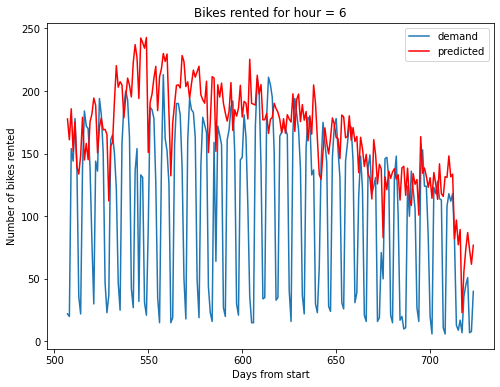

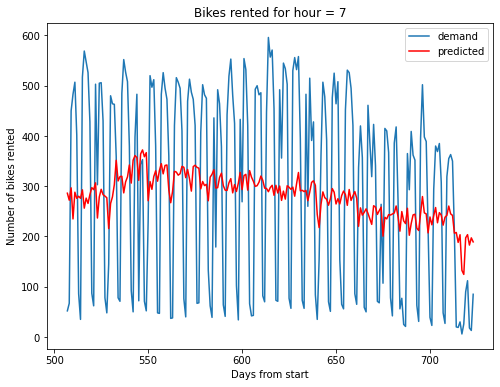

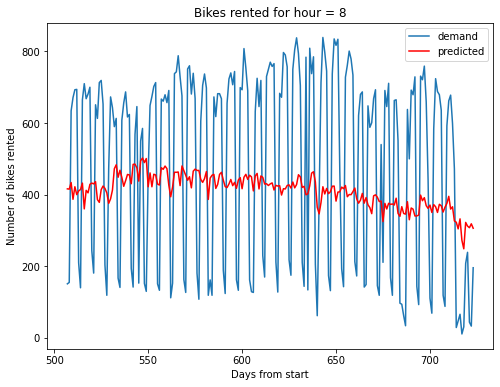

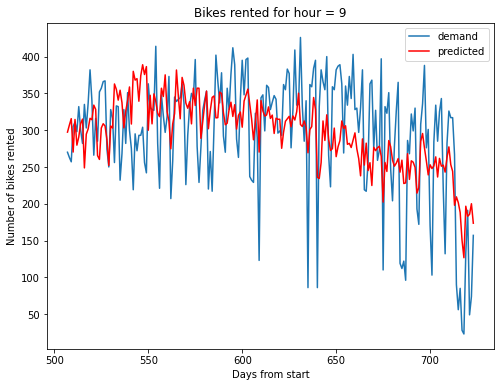

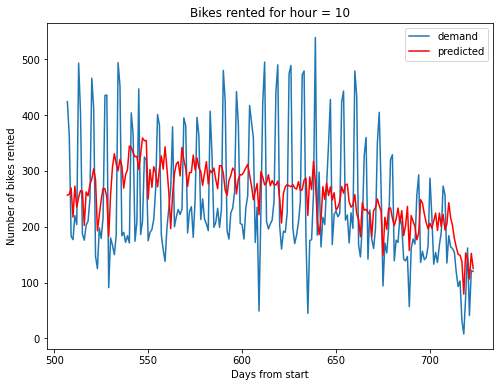

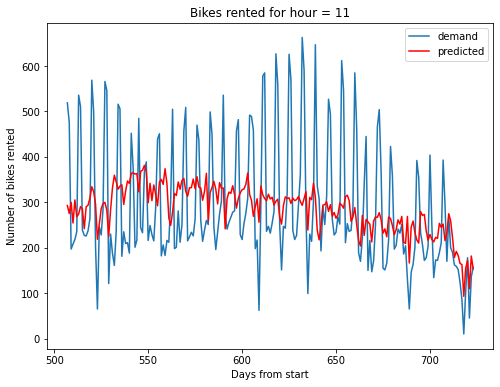

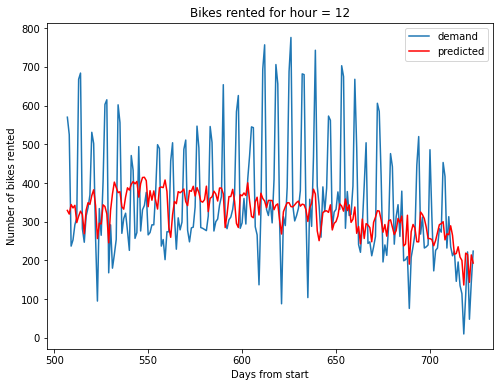

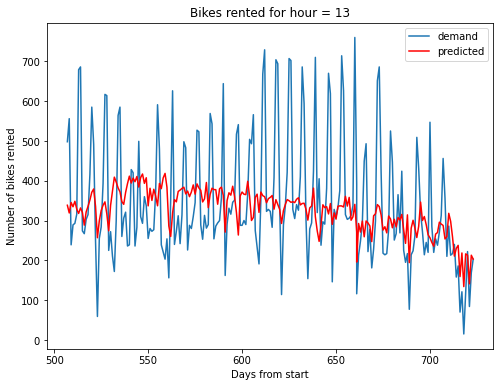

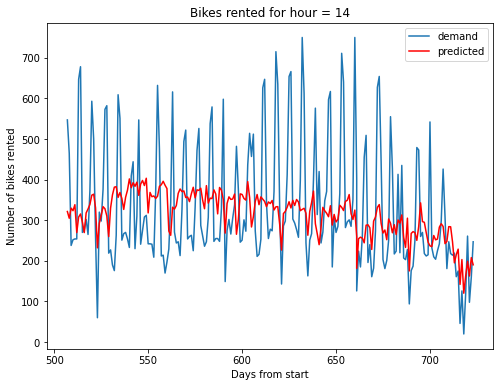

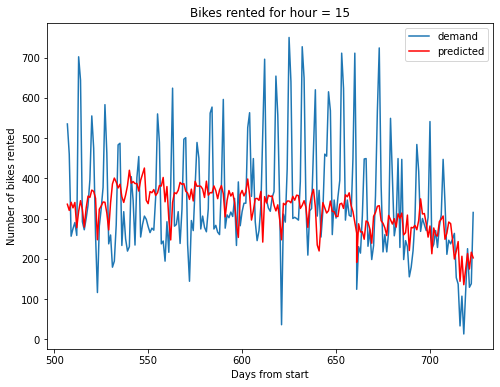

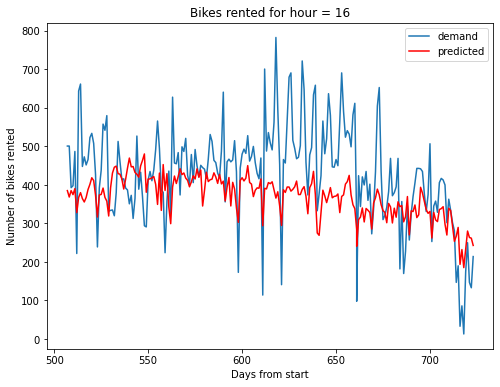

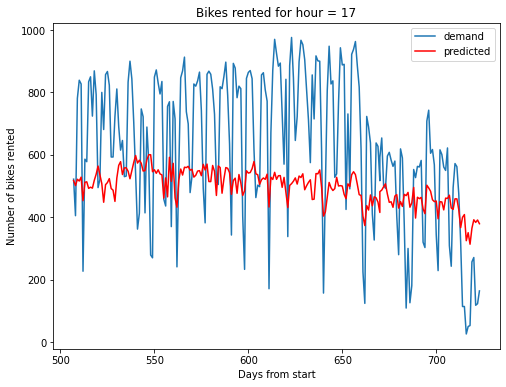

In [54]:
y_pred = reg.predict(X_test)  # predict the demand for X_test
X_test['predicted']=y_pred
X_test['demand']=y_test
ts_bikes(X_test, plt_times)

Visualize the residuals

'Done'

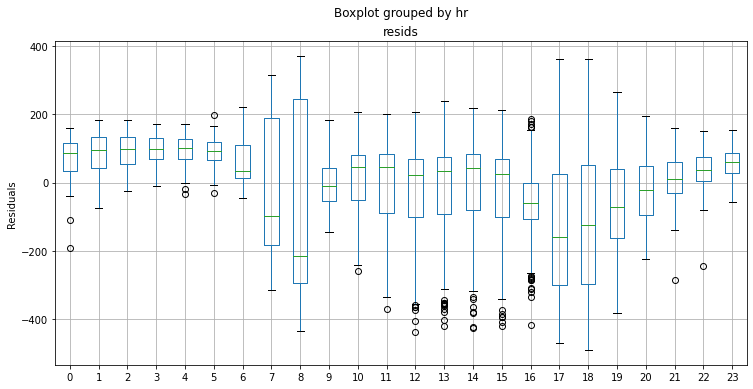

In [55]:
box_resids(X_test)

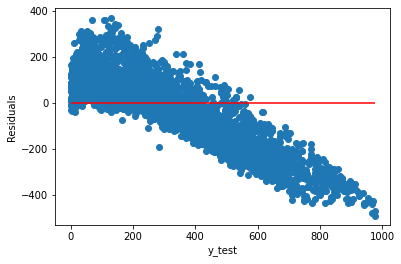

In [56]:
import matplotlib.pyplot as plt
plt.scatter(y_test, resids(X_test)['resids'])
plt.hlines(y=0, xmin=0,xmax=y_test.max(), color='r')
plt.xlabel('y_test')
plt.ylabel('Residuals')
plt.show()